## Notes
* This notebook has implementations of `Backprop` with binary spike feature vectors obtained from the `SPIKEFLOW`. Here, we will use tf.data API. Here the shape of the inputs is `[None, n_input]` instead of `[n_input, None]`. We had to do this because nested elements in `from_tensor_slices` must have the same dimension in 0th rank [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). Everytime an iterator `iter = dataset.make_initializable_iterator()` gets initialized, the dataset is randomly shuffled so we need not shuffle again, [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). 
* Here, error in the hidden layer, $\delta^{2}$ is implemented as:
$ \delta^{2} = W^{3T}\delta^{(3)}\odot\sigma^{'}(z^{(2)}) \tag{1}$
* $\sigma^{'}(z^{(2)})$ is replaced with spikes in hidden layer i.e, $a^{(2)}$.
## References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)

In [1]:
import os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline
import h5py, pickle
from keras.utils.np_utils import to_categorical 
import numpy as np
import pandas as pd
import seaborn as sb
import theano, random, sys, time

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
tf

1.14.0


<module 'tensorflow' from '/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

## Hide code

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25

## Load the data

In [5]:
filename = 'train_pool1_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_train_images = hf['pool1_spike_features'][:].astype(np.int8)
emnist_train_images[np.where(emnist_train_images>=1)] = 1
#emnist_train_images = theano.shared(emnist_train_images).dimshuffle(3,2,0,1).eval().reshape(1353588,-1)
print('Total train features:{}'.format(emnist_train_images.shape[0]))


filename = 'test_pool1_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_test_images = hf['pool1_spike_features'][:].astype(np.int8)
emnist_test_images[np.where(emnist_test_images>=1)] = 1
#emnist_test_images = theano.shared(emnist_test_images).dimshuffle(3,2,0,1).eval().reshape(225600,-1)
print('test features:{}'.format(emnist_test_images.shape[0]))


filehandle = open('train_y.pkl','rb')
emnist_train_labels = pickle.load(filehandle).astype(np.int).tolist()
filehandle.close()
emnist_train_labels = to_categorical(emnist_train_labels, num_classes=10)


filehandle = open('test_y.pkl','rb')
emnist_test_labels = pickle.load(filehandle).astype(np.int)
filehandle.close()
emnist_test_labels = to_categorical(emnist_test_labels, num_classes=10)
print('Length of test labels:{}'.format(emnist_test_labels.shape[0]))
n_images = len(emnist_train_images)


emnist_valid_images = emnist_train_images[0:int(0.09*n_images)]
print('Length of valid images:{}'.format(emnist_valid_images.shape[0]))
emnist_train_images = emnist_train_images[int(0.09*n_images):]
print('Length of train images:{}'.format(emnist_train_images.shape[0]))


emnist_valid_labels = emnist_train_labels[0:int(0.09*n_images)]
print('Length of valid labels:{}'.format(emnist_valid_labels.shape[0]))
emnist_train_labels = emnist_train_labels[int(0.09*n_images):]
print('Length of train labels:{}'.format(emnist_train_labels.shape[0]))
n_train = emnist_train_labels.shape[0]
n_test = emnist_test_labels.shape[0]
n_valid = emnist_valid_labels.shape[0]

all_train_images = emnist_train_images
all_train_labels = emnist_train_labels

BATCH_SIZE = 5
n_batches = len(all_train_images)/BATCH_SIZE
print('Number of batches:{}'.format(n_batches))

Total train features:60000
test features:10000
Length of test labels:10000
Length of valid images:5400
Length of train images:54600
Length of valid labels:5400
Length of train labels:54600
Number of batches:10920


batch_size = 5
epochs = 10
emnist_train_images = np.array_split(emnist_train_images, n_train/(batch_size))
emnist_train_labels = np.array_split(emnist_train_labels, n_train/(batch_size))
train_data = zip(emnist_train_images,emnist_train_labels)
print('Total number of epochs:{}'.format(epochs))
n_batches = len(train_data)
print('Number of batches in an epoch:{}'.format(n_batches))

## Start a session

In [6]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess= tf.InteractiveSession(config=config)
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

$tanh(x) = \frac{(e^{x} – e^{-x})}{(e^{x} + e^{-x})}$

$d\frac{tanh(x)}{dx} = 1 – (tanh(x))^{2}$

$\sigma(x) = \frac{1.0}{1 + e^{-x}}$

$d\frac{\sigma(x)}{dx} = \sigma(x)*(1 - \sigma(x))$

## Setup the network

In [7]:
n_input = 3630
n_middle = 1000
n_out = 10
batch_size = tf.placeholder(tf.int64, name='batch_size') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

drop_out = tf.placeholder(tf.float32)
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(2.0/(n_input))
    
    #w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    tf.summary.histogram('w_2', w_2)
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    tf.summary.histogram('b_2', b_2)
with tf.name_scope('op_lyr_w_b'):
    
    low = -tf.math.sqrt(2.0/(n_middle))
    high = tf.math.sqrt(2.0/(n_middle))
    #w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,10],minval=low,maxval=high), name = 'W_3')
    w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    tf.summary.histogram('w_3', w_3)
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))
def firstLyrSpks(x):
    return tf.where(tf.greater_equal(x,1.0), tf.ones_like(x), 
                        tf.zeros_like(x))


def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    #locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]),n_middle*batch_size )
    #locs_to_drop = tf.reshape(locs_to_drop, z_2.shape)
    #locs_to_drop = tf.reshape(locs_to_drop, [n_middle,batch_size])
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    a_2 = spkNeuron(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    z_3 = tf.floor(z_3)
    #z_3 = tf.subtract(tf.reduce_max(z_3),z_3, name = 'inhibition')
    tf.summary.histogram('z_3', z_3)
    #a_3  = spkNeuron(z_3) ##UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT spike SQUISHING
    a_3 = tf.nn.softmax(z_3,axis=1)
    tf.summary.histogram('a_3', a_3)
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    #a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),name = 'cost_calc')#WORKS
    ##COMMENT BELOW LINES IF YOU WANT SOFTMAX
    #dc_da = -tf.subtract(labels,a_3, name = 'y_minus_a_3')
    #cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = d_z_3
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.matmul(tf.transpose(a_2),d_z_3, name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), a_2, name = 'delta2')
    #d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = d_z_2
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.matmul((tf.transpose(features)),d_z_2, name = 'delta_w2')
    tf.summary.histogram('d_w_2', d_w_2)
    
eta = tf.constant(0.01)
step = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/tf.cast(batch_size, tf.float32), d_w_2)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2, axis=[0]),axis=0))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/tf.cast(batch_size, tf.float32), d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[0]),axis=0))))
]

with tf.name_scope('acc_calc'):
    predictions = tf.argmax(a_3, 1)
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)

path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/softmax_floor'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/train', sess.graph)
valid_writer = tf.summary.FileWriter(path + '/valid')

init_op = tf.global_variables_initializer()


## Commence training

In [8]:
epochs = 40
repeats = 5
all_best_val_accs = []
all_best_test_accs = []
all_final_test_accs = []

for repeat in range(repeats):
    print('Repeat:{}'.format(repeat))
    tf.set_random_seed(repeat)
    sess.run(init_op,options=run_options, run_metadata=run_metadata)
    train_accuracies = []
    train_costs = []
    val_accuracies = []
    val_costs = []
    best_val = 0
    best_params = None
    logging_count = 0
    best_predictions = None ##for valid data
    best_predictions_test = None
    predictions_test = None
    best_classifications = None
    best_activations = None ##for valid data
    best_activations_test = None
    activations_test = None

    T1 = time.time()
    for i in range(epochs):

        sess.run(iter.initializer, feed_dict={ a_1: all_train_images, y: all_train_labels,
                                              batch_size: len(all_train_images)})
        print('Epoch:{}'.format((i)))
        t1 = time.time()

        ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
        ## train cost
        #summary, train_cost = sess.run([merged,cost], feed_dict = {a_1 : all_train_images.transpose(),
        #                                            y : all_train_labels.transpose()})
        #train_writer.add_summary(summary,i)  OOM ERROR
        #train_cost, train_accuracy = sess.run([cost,acct_res] ,feed_dict = {drop_out : 0.0 ,a_1: all_train_images, 
        #                                      y: all_train_labels,batch_size: len(all_train_images)})
        train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0})
        train_costs.append(train_cost)
        train_accuracies.append(train_accuracy)
        #train_writer.add_summary(summary,logging_count)

        print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

        ### CALCULATE VALID COSTS AND VALID ACCURACIES
        sess.run(iter.initializer, feed_dict={ a_1: emnist_valid_images, y: emnist_valid_labels,
                                              batch_size: len(emnist_valid_images)})
        ## valid cost
        #summary, val_cost, val_acc = sess.run([merged,cost,acct_res], feed_dict = {drop_out : 0.0, a_1: emnist_valid_images, 
        #                                            y: emnist_valid_labels,batch_size: len(emnist_valid_images)} )
        all_predictions, classifications, val_acc, val_cost, activ = sess.run([predictions, 
                                                                                        acct_mat, 
                                                                                        acct_res, cost, a_3], 
                                                                             feed_dict = {drop_out : 0.0})
        val_costs.append(val_cost)
        val_accuracies.append(val_acc)
        #valid_writer.add_summary(summary,i)

        if(val_acc>best_val):
            best_val = val_acc
            best_params = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
            best_predictions = all_predictions
            best_classifications = classifications
            best_activations = activ

        print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   

        sess.run(iter.initializer, feed_dict={a_1: all_train_images, y: all_train_labels,
                                              batch_size: BATCH_SIZE})


        for j in range(n_batches):

            if(((j+1)% 5000 ==0)):
                logging_count+=1
                summary,_ = sess.run([merged,step], feed_dict = {drop_out:0.5,batch_size: BATCH_SIZE})
                #train_writer.add_summary(summary, (i+1)*j)
                train_writer.add_summary(summary, logging_count)
            else:
                sess.run(step, feed_dict = {drop_out:0.5,batch_size: BATCH_SIZE})
        print('Epoch time:{}'.format(time.time()-t1))

        #logging_count+=1

    sess.run(iter.initializer, feed_dict={ a_1: emnist_test_images, y: emnist_test_labels,
                                              batch_size: len(emnist_test_images)})
    predictions_test,test_acc,activations_test = sess.run([predictions, acct_res, a_3], feed_dict = {drop_out:0.0})


    print('Final test accuracy is:{}'.format(test_acc))
    all_final_test_accs.append(test_acc)
    best_step = [tf.assign(w_2,best_params[0][0]), tf.assign(b_2,best_params[0][1]),tf.assign(w_3,best_params[1][0]),\
        tf.assign(b_3,best_params[1][1])]

    sess.run(best_step)
    sess.run(iter.initializer, feed_dict={a_1: emnist_test_images, y: emnist_test_labels,
                                              batch_size: len(emnist_test_images)})
    best_predictions_test,test_acc,best_activations_test = sess.run([predictions, acct_res, a_3], 
                                                                    feed_dict = {drop_out:0.0})


    print('Test accuracy corresp to best val acc:{}'.format(test_acc))
    print('Time taken:{}'.format(time.time()-T1))
    train_writer.close()
    valid_writer.close()
    
    all_best_test_accs.append(test_acc)
    all_best_val_accs.append(max(val_accuracies))
    #tf.reset_default_graph()


Repeat:0
Epoch:0
training cost:2.43983769417 and training accuracy:0.119597069919
validation cost:2.44830322266 and validation accuracy:0.109629631042
Epoch time:48.3304629326
Epoch:1
training cost:0.175454750657 and training accuracy:0.953333318233
validation cost:0.194688692689 and validation accuracy:0.953518509865
Epoch time:46.4141631126
Epoch:2
training cost:0.134862944484 and training accuracy:0.967069625854
validation cost:0.17983174324 and validation accuracy:0.962407410145
Epoch time:44.218102932
Epoch:3
training cost:0.11608850956 and training accuracy:0.972783863544
validation cost:0.183304876089 and validation accuracy:0.964629650116
Epoch time:44.9947659969
Epoch:4
training cost:0.0965919047594 and training accuracy:0.977142870426
validation cost:0.175692990422 and validation accuracy:0.966111123562
Epoch time:45.9065699577
Epoch:5
training cost:0.0763728022575 and training accuracy:0.981923103333
validation cost:0.162824079394 and validation accuracy:0.9705555439
Epoch t

/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/python/summary/writer/writer.py:386: UserWarning: Attempting to use a closed FileWriter. The operation will be a noop unless the FileWriter is explicitly reopened.
  warnings.warn("Attempting to use a closed FileWriter. "


Epoch time:43.7507030964
Epoch:1
training cost:0.181482374668 and training accuracy:0.952527463436
validation cost:0.202258214355 and validation accuracy:0.952777802944
Epoch time:44.1426689625
Epoch:2
training cost:0.125128701329 and training accuracy:0.969157516956
validation cost:0.17226845026 and validation accuracy:0.966111123562
Epoch time:44.3939299583
Epoch:3
training cost:0.104232251644 and training accuracy:0.975238084793
validation cost:0.169065192342 and validation accuracy:0.965740740299
Epoch time:44.0757200718
Epoch:4
training cost:0.087800167501 and training accuracy:0.979010999203
validation cost:0.162526965141 and validation accuracy:0.969444453716
Epoch time:44.0606369972
Epoch:5
training cost:0.0785302817822 and training accuracy:0.981062293053
validation cost:0.162633910775 and validation accuracy:0.970370352268
Epoch time:44.237981081
Epoch:6
training cost:0.0688022449613 and training accuracy:0.983479857445
validation cost:0.161496475339 and validation accuracy:0

validation cost:0.162503480911 and validation accuracy:0.971481502056
Epoch time:43.9270451069
Epoch:9
training cost:0.0515965186059 and training accuracy:0.986977994442
validation cost:0.16604372859 and validation accuracy:0.971481502056
Epoch time:43.7836019993
Epoch:10
training cost:0.0503802597523 and training accuracy:0.987161159515
validation cost:0.167861685157 and validation accuracy:0.970185160637
Epoch time:44.2055599689
Epoch:11
training cost:0.046830419451 and training accuracy:0.988168478012
validation cost:0.169685810804 and validation accuracy:0.972407400608
Epoch time:43.6500840187
Epoch:12
training cost:0.0405610240996 and training accuracy:0.989652037621
validation cost:0.165162622929 and validation accuracy:0.972777783871
Epoch time:43.8964300156
Epoch:13
training cost:0.0375798866153 and training accuracy:0.990402936935
validation cost:0.164376974106 and validation accuracy:0.972407400608
Epoch time:43.9037230015
Epoch:14
training cost:0.0398493409157 and training a

Epoch time:44.3938531876
Epoch:16
training cost:0.0334933400154 and training accuracy:0.991227090359
validation cost:0.176164850593 and validation accuracy:0.972407400608
Epoch time:44.0225939751
Epoch:17
training cost:0.0300208628178 and training accuracy:0.991868138313
validation cost:0.17561557889 and validation accuracy:0.973518490791
Epoch time:43.8432998657
Epoch:18
training cost:0.026918226853 and training accuracy:0.992655694485
validation cost:0.175696566701 and validation accuracy:0.974629640579
Epoch time:43.9701230526
Epoch:19
training cost:0.026870470494 and training accuracy:0.992948710918
validation cost:0.176789283752 and validation accuracy:0.974259257317
Epoch time:44.1521019936
Epoch:20
training cost:0.0259388852865 and training accuracy:0.9932051301
validation cost:0.180814370513 and validation accuracy:0.973333358765
Epoch time:43.6323800087
Epoch:21
training cost:0.0218745302409 and training accuracy:0.994212448597
validation cost:0.17185343802 and validation accu

validation cost:0.16844189167 and validation accuracy:0.974814832211
Epoch time:44.0219900608
Epoch:24
training cost:0.0217261984944 and training accuracy:0.993974387646
validation cost:0.177094697952 and validation accuracy:0.974074065685
Epoch time:43.6549370289
Epoch:25
training cost:0.0179800931364 and training accuracy:0.994963347912
validation cost:0.172792747617 and validation accuracy:0.9753703475
Epoch time:44.3796908855
Epoch:26
training cost:0.020108114928 and training accuracy:0.99439561367
validation cost:0.181736320257 and validation accuracy:0.973518490791
Epoch time:44.4630579948
Epoch:27
training cost:0.0162072833627 and training accuracy:0.99558609724
validation cost:0.178744629025 and validation accuracy:0.974074065685
Epoch time:43.9643080235
Epoch:28
training cost:0.0148663921282 and training accuracy:0.996153831482
validation cost:0.180385202169 and validation accuracy:0.975185155869
Epoch time:43.8737120628
Epoch:29
training cost:0.014730735682 and training accur

## Inspecting misclassified labels

In [9]:
all_best_val_accs = np.array(all_best_val_accs)
print('best validation:{}, mean validation:{}, std validation:{}'.format(all_best_val_accs.max(),
                                                                        all_best_val_accs.mean(),
                                                                         all_best_val_accs.std()))
all_best_test_accs = np.array(all_best_test_accs)
print('best test:{}, mean test:{}, std test:{}'.format(all_best_test_accs.max(),
                                                                        all_best_test_accs.mean(),
                                                                         all_best_test_accs.std()))

all_final_test_accs = np.array(all_final_test_accs)
print('best test:{}, mean test:{}, std test:{}'.format(all_final_test_accs.max(),
                                                                        all_final_test_accs.mean(),
                                                                         all_final_test_accs.std()))

best validation:0.976111114025, mean validation:0.975444436073, std validation:0.000626347435173
best test:0.976800024509, mean test:0.975959956646, std test:0.000659097277094
best test:0.97729998827, mean test:0.97556000948, std test:0.00114121416118


In [10]:
right_classify_indices = np.where(best_classifications==True)[0].tolist()
wrong_classify_indices = np.where(best_classifications==False)[0].tolist()
right_predict_labels = best_predictions[np.array(best_classifications)]
wrong_predict_labels = best_predictions[~np.array(best_classifications)]

print(len(right_classify_indices))
print(len(wrong_classify_indices))

right_classify_indices[0:10]

5271
129


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [11]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9'}

In [12]:
original_valid_labels_scalar = emnist_valid_labels.argmax(axis=1)
correct_preds = 0
samples_per_class = [0]*10
correct_classifications_per_class = [0]*10
heat_map_data = np.zeros((10,10))
for i in range(len(original_valid_labels_scalar)):
    true_label = original_valid_labels_scalar[i]
    samples_per_class[true_label]+=1.0
    predicted_label = best_activations[i].argmax()
    heat_map_data[true_label][predicted_label]+=1.0
    if(true_label == predicted_label):
        correct_classifications_per_class[predicted_label]+=1.0
        correct_preds+=1
print('Number of mis-matches:{}'.format(len(original_valid_labels_scalar) - correct_preds))
print('Validation aaccuracy:{}'.format(float(correct_preds)/len(original_valid_labels_scalar)))

Number of mis-matches:129
Validation aaccuracy:0.976111111111


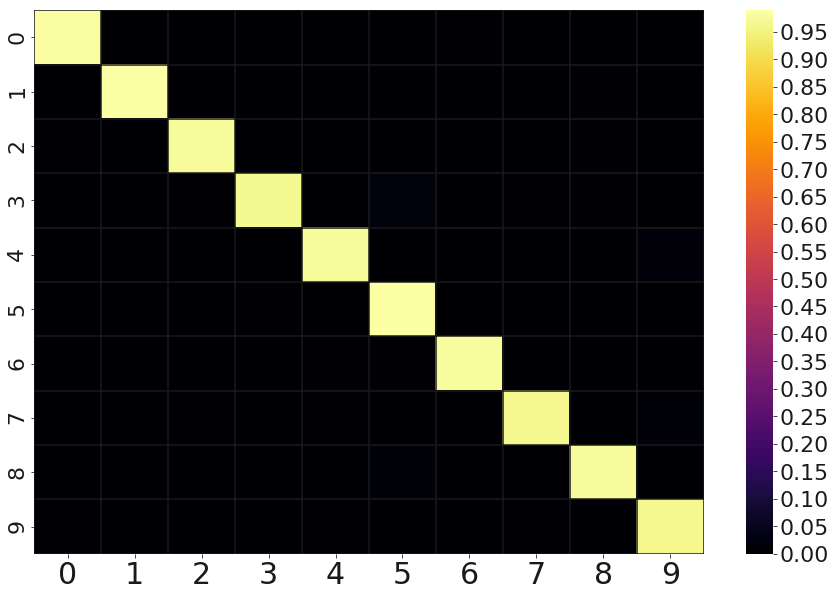

In [13]:
heat_map_df = pd.DataFrame(heat_map_data/heat_map_data.sum(axis=1, keepdims=True), columns = [labels_map[i] for i in range(10)], 
                           index = [labels_map[i] for i in range(10)] )
#sb.palplot(sb.diverging_palette(200, 100, n=47)) cubehelix  
ax = sb.heatmap(heat_map_df, annot=False, cbar=True,cbar_kws={"ticks":[0.05*i for i in range(21)]},
               cmap="inferno")
sb.set(font_scale=3.15)
ax.hlines([range(47)], *ax.get_xlim())
ax.vlines([range(47)], *ax.get_xlim())
plt.savefig('mnist_results/heatmap_spikeprop_softmax_v1.pdf')
plt.savefig('mnist_results/heatmap_spikeprop_softmax_v1.png')
plt.savefig('mnist_results/heatmap_spikeprop_softmax_v1.eps')
plt.show()

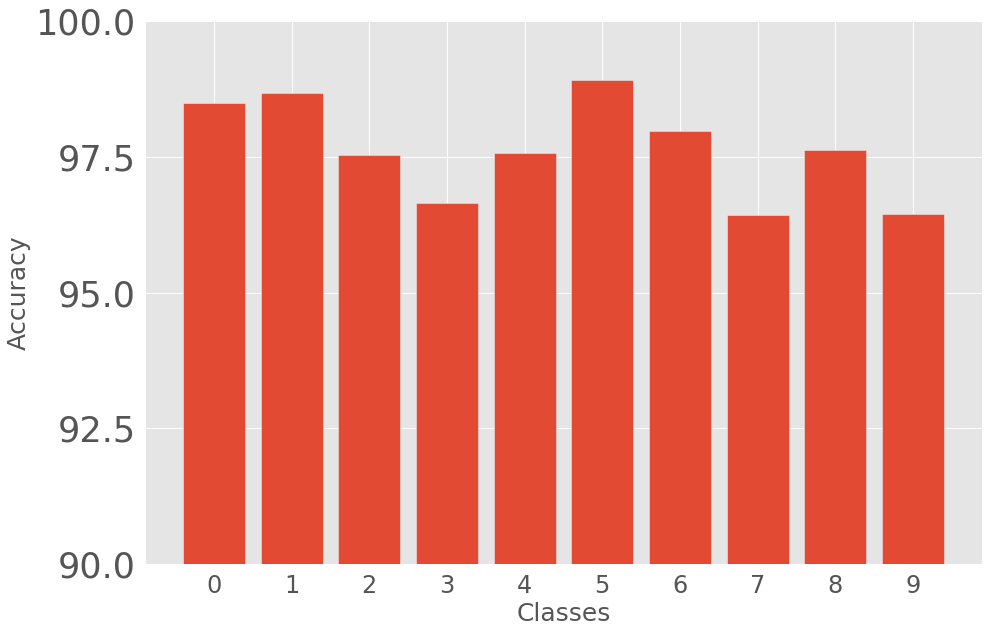

In [14]:
plt.style.use('ggplot')
classwise_accuracy = 100*np.array(correct_classifications_per_class)/np.array(samples_per_class)
plt.bar(range(len(classwise_accuracy)), classwise_accuracy)
#plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.0)
plt.grid(b=True, which='minor', color='w', linestyle='-', alpha=1.0)
plt.xlabel('Classes',fontsize=25)
plt.ylabel('Accuracy',fontsize=25)
#plt.xlim(-0.5,len(classwise_accuracy))
plt.yticks([2.5*i for i in range(42)],fontsize=35)
#plt.yscale('log')
plt.xticks(range(10),[labels_map[i] for i in range(10)],fontsize=24)
plt.ylim(90,100.0)
plt.savefig('mnist_results/acc_per_class_spikeprop_softmax_v1.pdf')
plt.savefig('mnist_results/acc_per_class_spikeprop_softmax_v1.png')
plt.savefig('mnist_results/acc_per_class_spikeprop_softmax_v1.eps')
plt.show()


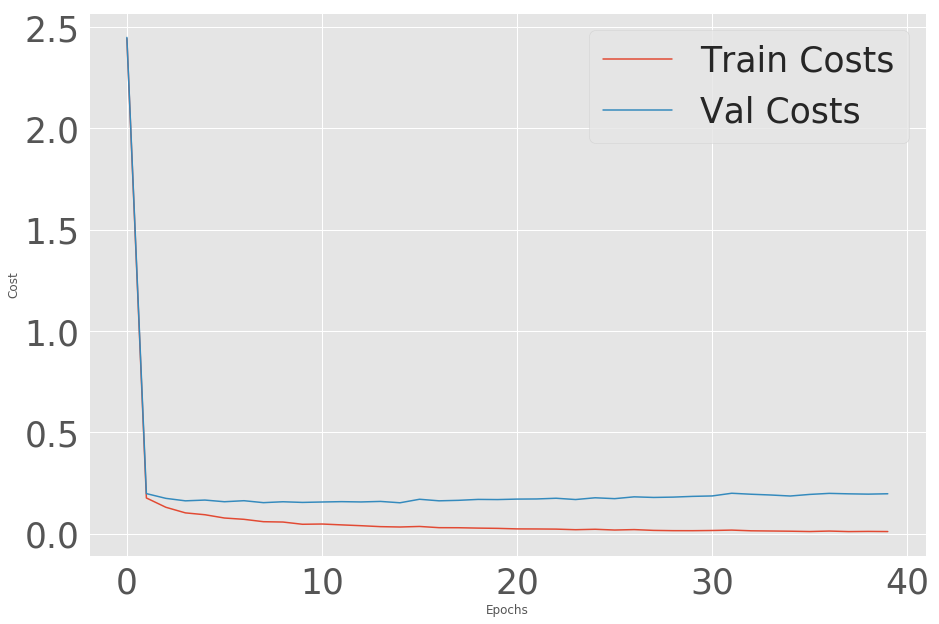

In [15]:
plt.style.use('ggplot')
plt.plot(train_costs, label="Train Costs")
plt.plot(val_costs, label="Val Costs")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid(b=True, which='major', color='w', linestyle='-',alpha=1.0)
#plt.grid(b=True, which='minor', color='w', linestyle='-', alpha=1.0)
plt.legend()
plt.show()

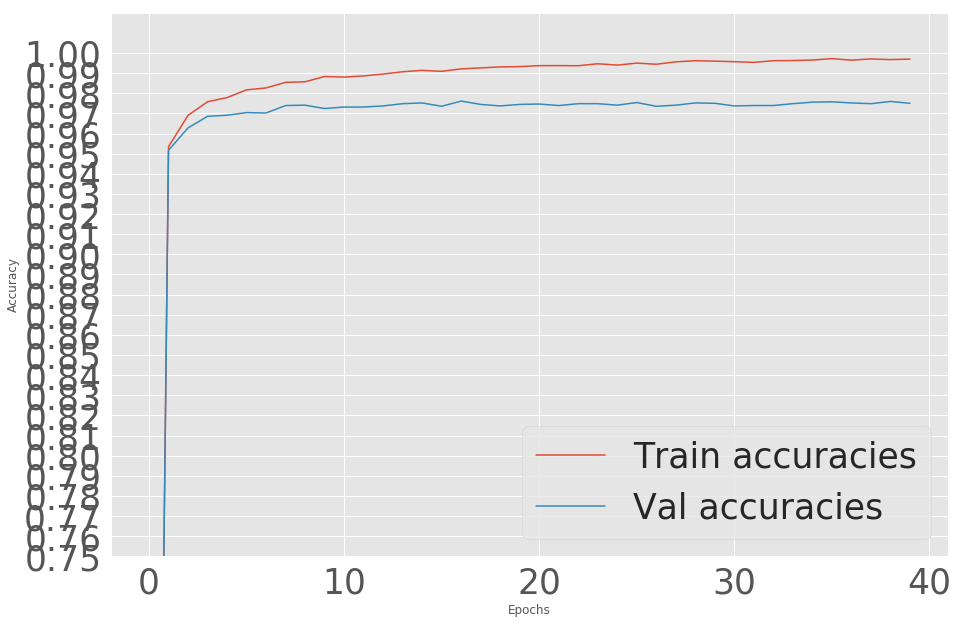

In [16]:
plt.plot(train_accuracies, label="Train accuracies")
plt.plot(val_accuracies, label="Val accuracies")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.01*i for i in range(1,101)])
plt.ylim(0.75,1.02)
plt.grid(b=True, which='major', color='w', linestyle='-',alpha=1.0)
plt.legend()
plt.show()

In [17]:
sys.exit()

SystemExit: 

/home/ruthvik/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/'
writer = tf.summary.FileWriter(path, sess.graph)
writer.flush()
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open(path+'/timeline.json', 'w') as f:
    f.write(ctf)


writer.add_run_metadata(run_metadata, 'mysess')
writer.flush()
writer.close()